<a href="https://colab.research.google.com/github/aasrithanarra/Water-quality-prediction/blob/main/Water_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('PB_All_2000_2021.csv', sep=';')

# Basic info
print("Shape of the dataset:", df.shape)
print("\nData Types and Non-Null Counts:")
print(df.info())

# Preview the data
df.head()


Shape of the dataset: (2861, 11)

Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2861 entries, 0 to 2860
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2861 non-null   int64  
 1   date       2861 non-null   object 
 2   NH4        2858 non-null   float64
 3   BSK5       2860 non-null   float64
 4   Suspended  2845 non-null   float64
 5   O2         2858 non-null   float64
 6   NO3        2860 non-null   float64
 7   NO2        2858 non-null   float64
 8   SO4        2812 non-null   float64
 9   PO4        2833 non-null   float64
 10  CL         2812 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 246.0+ KB
None


,id,date,NH4,BSK5,Suspended,O2,NO3,NO2,SO4,PO4,CL
0,1,17.02.2000,0.330,2.77,12.0,12.30,9.50,0.057,154.0,0.454,289.5
1,1,11.05.2000,0.044,3.00,51.6,14.61,17.75,0.034,352.0,0.090,1792.0
2,1,11.09.2000,0.032,2.10,24.5,9.87,13.80,0.173,416.0,0.200,2509.0
3,1,13.12.2000,0.170,2.23,35.6,12.40,17.13,0.099,275.2,0.377,1264.0
4,1,02.03.2001,0.000,3.03,48.8,14.69,10.00,0.065,281.6,0.134,1462.0


In [2]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
id            0
date          0
NH4           3
BSK5          1
Suspended    16
O2            3
NO3           1
NO2           3
SO4          49
PO4          28
CL           49
dtype: int64


In [3]:
# Convert 'date' to datetime format
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Extract Year (optional)
df['year'] = df['date'].dt.year

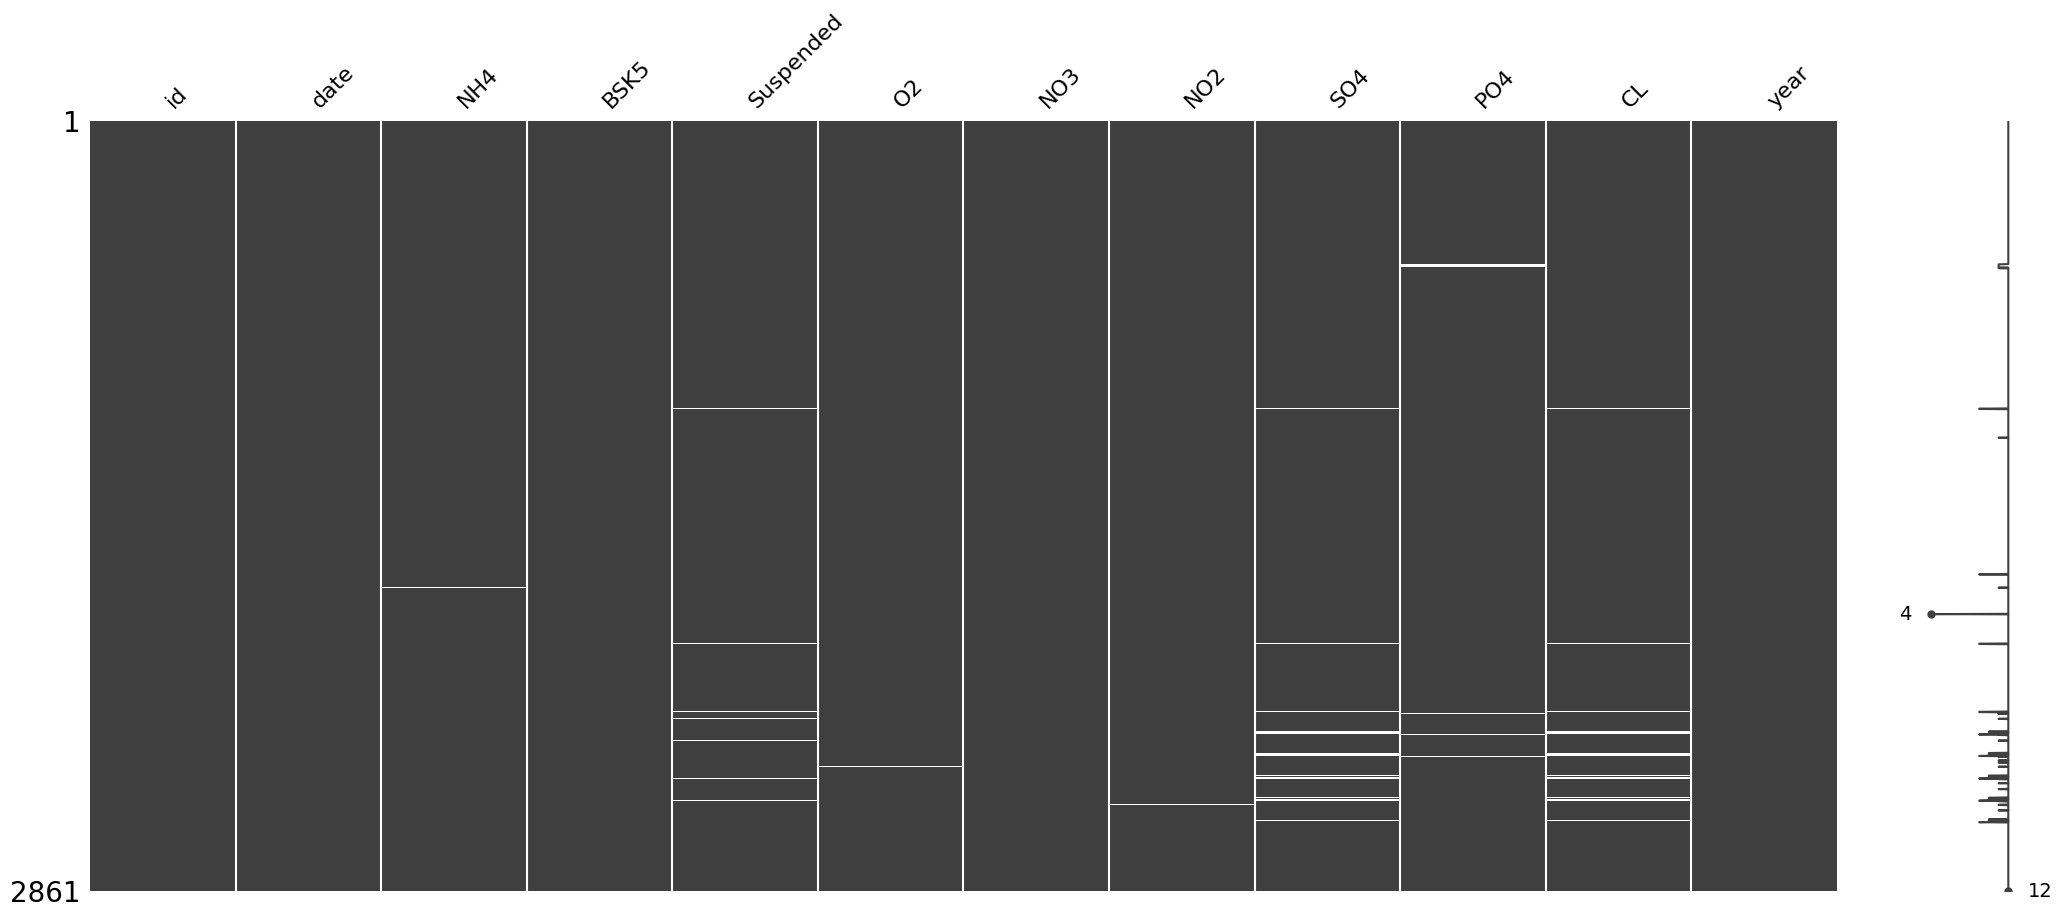

In [4]:
import missingno as msno

# Visual representation of missing data
msno.matrix(df)
plt.show()


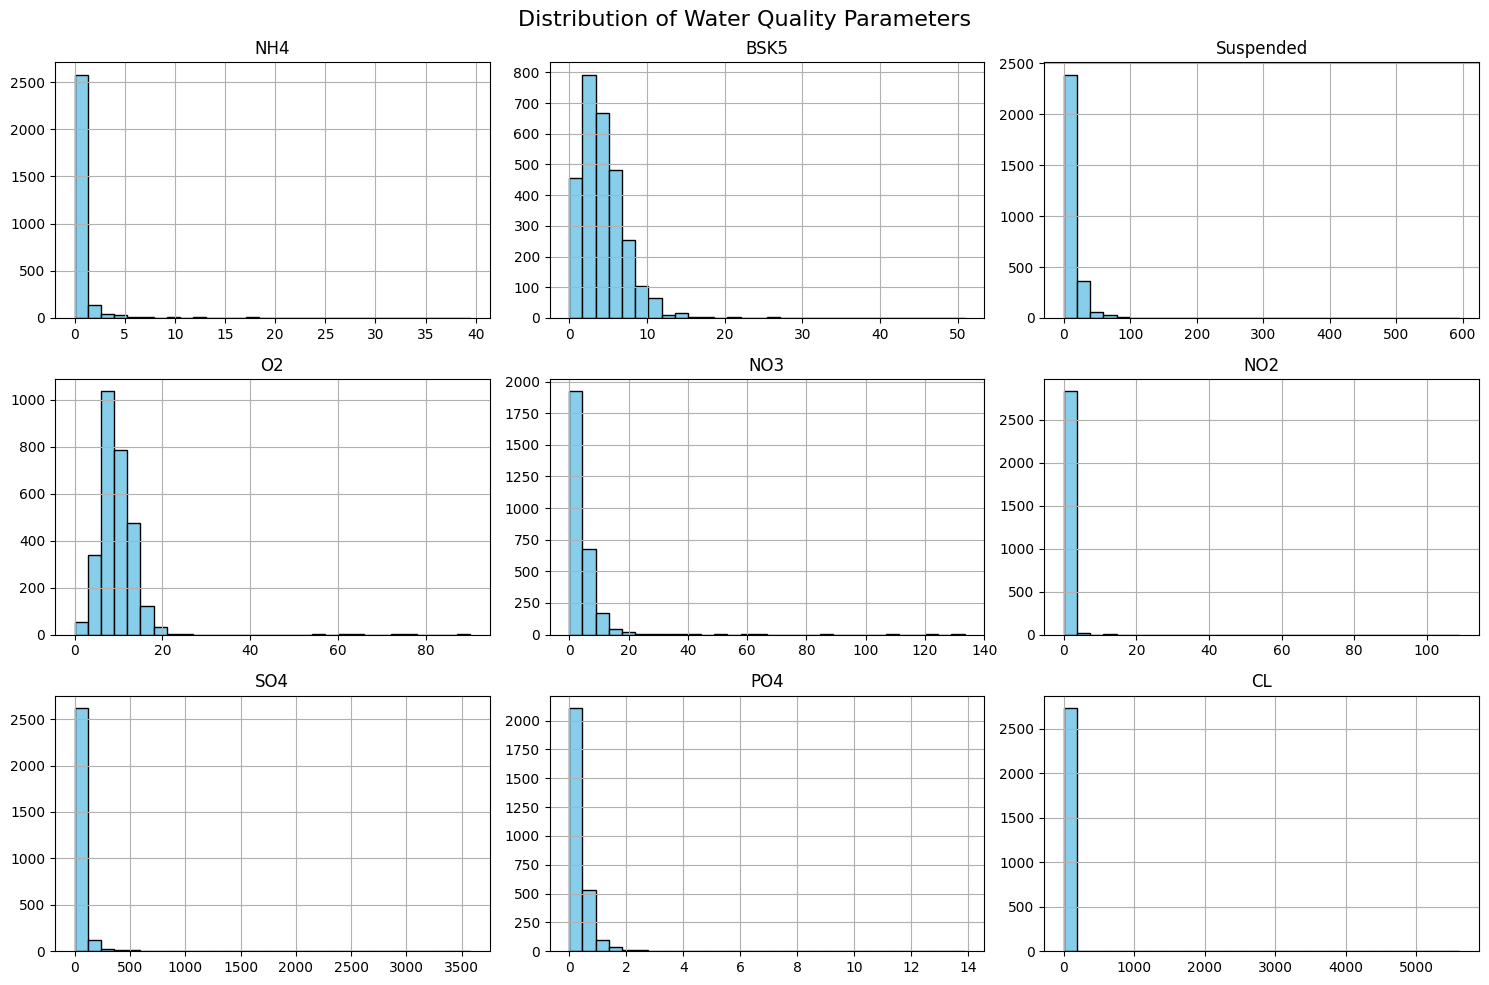

In [5]:
# Plot distributions of all numeric parameters
num_cols = ['NH4', 'BSK5', 'Suspended', 'O2', 'NO3', 'NO2', 'SO4', 'PO4', 'CL']

df[num_cols].hist(bins=30, figsize=(15, 10), color='skyblue', edgecolor='black')
plt.suptitle('Distribution of Water Quality Parameters', fontsize=16)
plt.tight_layout()
plt.show()


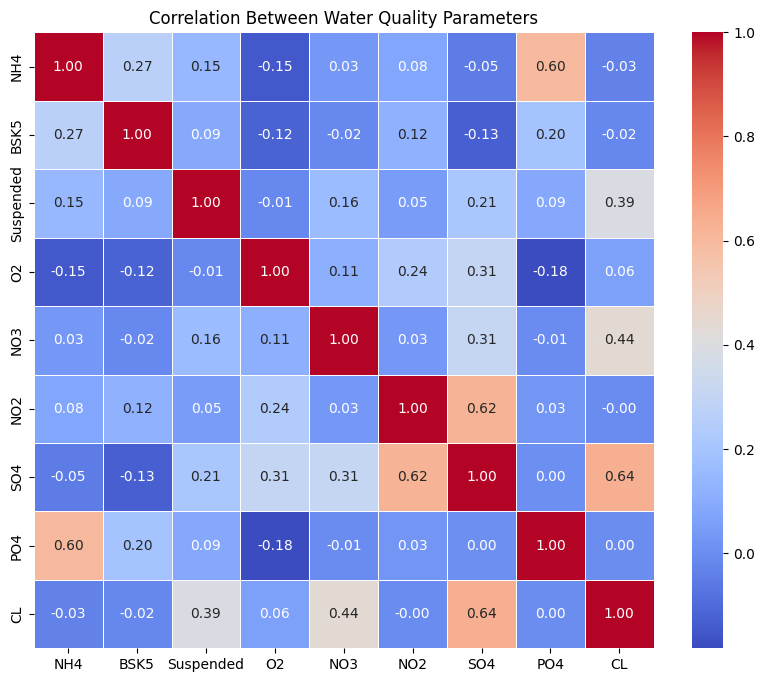

In [6]:
# Compute correlation matrix
corr_matrix = df[num_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Between Water Quality Parameters')
plt.show()
